---
# PREPROCESS RAW DATA

In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
import gc

#needed to import utils.py
sys.path.append('../') 

import utils
import utils_preprocessing
import utils_time_series_generation

import numpy as np
import pandas as pd

%matplotlib inline  

---
# 1. Read data from the `demographics` csv file

In [2]:
#set the data directory
data_dir = os.path.abspath('../01_raw_data')

#set the name of CSV file
data_file = f'{data_dir}/PROACT_DEMOGRAPHICS.csv'

#read data and show some info
df = utils.read_csv(data_file)

print(df.shape[0])

df.head()

11675


,subject_id,Demographics_Delta,Age,Date_of_Birth,Ethnicity,Race_Americ_Indian_Alaska_Native,Race_Asian,Race_Black_African_American,Race_Hawaiian_Pacific_Islander,Race_Unknown,Race_Caucasian,Race_Other,Race_Other_Specify,Sex
0,89,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Male
1,329,0.0,38.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,Female
2,348,0.0,52.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,Female
3,406,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Male
4,411,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Male


## Show columns stats and missingness

In [3]:
utils.show_columns_stats(df)

subject_id...................... = 11675 rows (100.0%)     0 with NaN (  0.0%) Uniques= 11675 
Demographics_Delta.............. = 11590 rows (99.27%)    85 with NaN ( 0.73%) Uniques=    12 
Age............................. =  8654 rows (74.12%)  3021 with NaN (25.88%) Uniques=   195 
Date_of_Birth................... =  1298 rows (11.12%) 10377 with NaN (88.88%) Uniques=  1235 
Ethnicity....................... =  2936 rows (25.15%)  8739 with NaN (74.85%) Uniques=     4 
Race_Americ_Indian_Alaska_Native =    12 rows (  0.1%) 11663 with NaN ( 99.9%) Uniques=     2 
Race_Asian...................... =    73 rows ( 0.63%) 11602 with NaN (99.37%) Uniques=     2 
Race_Black_African_American..... =   136 rows ( 1.16%) 11539 with NaN (98.84%) Uniques=     2 
Race_Hawaiian_Pacific_Islander.. =     1 rows ( 0.01%) 11674 with NaN (99.99%) Uniques=     2 
Race_Unknown.................... =    25 rows ( 0.21%) 11650 with NaN (99.79%) Uniques=     2 
Race_Caucasian.................. =  7581 rows (64.

## Calculate the Age for those samples having `Age=NaN` and `Date_of_Birth<>NaN`
### Calculation based on delta days in Date_of_Birth column

In [4]:
#get samples with Age=NaN and Date_of_Birth<>NaN
df_calc_age_from_birth = df.loc[(df.Age.isnull()) & (df.Date_of_Birth.isnull()==False)]
print(f'Age calculated for {utils.get_quantity_of_rows(df_calc_age_from_birth)} samples')

#calculate the Age from the Date_of_Birth delta (in days and negative)
ages_calculated = df_calc_age_from_birth.Date_of_Birth.apply( lambda x: utils.calculate_age_from_birth_delta(np.abs(x)) )

#update samples with the calculated Age
df.loc[df_calc_age_from_birth.index,'Age'] = ages_calculated



Age calculated for 944 samples


##### We can note that now the Age column has 82.21% of non-NaN values (previously had 74.12%) 

In [5]:
utils.show_columns_stats(df, ['Age'])

Age =  9598 rows (82.21%)  2077 with NaN (17.79%) Uniques=   195 


### Remove irrelevant columns for this study, which are:
- `Demographics_Delta` column
- `Date_of_Birth` column (not necessary, using `Age` column), 
- `Ethnicity` column (high number of missing values)
- All `Race_*` columns (high number of missing values)

In [6]:
irrelevant_cols = ['Demographics_Delta', 'Date_of_Birth', 'Ethnicity', 'Race_Americ_Indian_Alaska_Native', 'Race_Asian',
                   'Race_Black_African_American', 'Race_Hawaiian_Pacific_Islander', 'Race_Unknown', 'Race_Caucasian', 
                   'Race_Other', 'Race_Other_Specify']

df.drop(columns=irrelevant_cols, inplace=True)
df.head()

,subject_id,Age,Sex
0,89,NaN,Male
1,329,38.0,Female
2,348,52.0,Female
3,406,NaN,Male
4,411,NaN,Male


----
----
----
## Remove rows with NaN in the AGE and SEX columns

In [7]:
# AGE column
to_delete = df.loc[(df.Age.isnull())]
df = utils.remove_rows(df=df, to_delete=to_delete, info='AGE')


# SEX column
to_delete = df.loc[(df.Sex.isnull())]
df = utils.remove_rows(df=df, to_delete=to_delete, info='SEX')

df


  - AGE Previous=11675, To delete=2077, After=9598
  - SEX Previous=9598, To delete=0, After=9598


,subject_id,Age,Sex
1,329,38.0,Female
2,348,52.0,Female
5,533,65.0,Female
6,586,63.0,Male
7,649,48.0,Female
...,...,...,...
11670,22564,63.0,Male
11671,160135,67.0,Female
11672,304192,59.0,Female
11673,820199,49.0,Male


### Check if all columns contain values (i.e., without missing values)

In [8]:
utils.show_columns_stats(df, df.columns)

subject_id =  9598 rows (100.0%)     0 with NaN (  0.0%) Uniques=  9598 
Age....... =  9598 rows (100.0%)     0 with NaN (  0.0%) Uniques=   194 
Sex....... =  9598 rows (100.0%)     0 with NaN (  0.0%) Uniques=     2 


----
## Save the pre-processed data to CSV file

In [9]:
dir_dest = os.path.abspath('../03_preprocessed_data/')
csv_dest = f'{dir_dest}/patient.csv'
utils.save_to_csv(df=df, csv_file=csv_dest)


9598 samples were saved


---
# 2. Preprocessing `ALS History`
---

## Read ALS History data file

In [10]:
#set the data directory
data_dir = os.path.abspath('../01_raw_data/')

#set the name of CSV file
data_file = f'{data_dir}/PROACT_ALSHISTORY.csv'

#read data and show some info
df_raw = utils.read_csv(data_file)

df_raw.head()

,subject_id,Site_of_Onset___Bulbar,Site_of_Onset___Limb,Site_of_Onset___Limb_and_Bulbar,Site_of_Onset___Other,Site_of_Onset___Other_Specify,Site_of_Onset___Spine,Subject_ALS_History_Delta,Disease_Duration,Symptom,Symptom_Other_Specify,Location,Location_Other_Specify,Site_of_Onset,Onset_Delta,Diagnosis_Delta
0,89,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,329,NaN,1.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,-1706.0,-1068.0
2,348,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,Onset: Other,-501.0,-302.0
3,406,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,411,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Show columns stats and missingness

In [11]:
utils.show_columns_stats(df_raw) 


subject_id..................... = 12936 rows (100.0%)     0 with NaN (  0.0%) Uniques= 10271 
Site_of_Onset___Bulbar......... =  1281 rows (  9.9%) 11655 with NaN ( 90.1%) Uniques=     3 
Site_of_Onset___Limb........... =  3589 rows (27.74%)  9347 with NaN (72.26%) Uniques=     3 
Site_of_Onset___Limb_and_Bulbar =     0 rows (  0.0%) 12936 with NaN (100.0%) Uniques=     1 
Site_of_Onset___Other.......... =     0 rows (  0.0%) 12936 with NaN (100.0%) Uniques=     1 
Site_of_Onset___Other_Specify.. =     0 rows (  0.0%) 12936 with NaN (100.0%) Uniques=     1 
Site_of_Onset___Spine.......... =     0 rows (  0.0%) 12936 with NaN (100.0%) Uniques=     1 
Subject_ALS_History_Delta...... =  9583 rows (74.08%)  3353 with NaN (25.92%) Uniques=     5 
Disease_Duration............... =     0 rows (  0.0%) 12936 with NaN (100.0%) Uniques=     1 
Symptom........................ =  2656 rows (20.53%) 10280 with NaN (79.47%) Uniques=    11 
Symptom_Other_Specify.......... =    50 rows ( 0.39%) 12886 

## Correct the duplicate `subject_id` problem in `RAW Data`


NOTE: apparently the reason for duplication `subject_id` values is because in #1 row was assigned the `Symptom` column, and the #2 row the `Onset_Delta` column

SOLUTION: group samples by `subject_id` column, and use `first()` function to get the first `non-NaN` value for each column

After merge values, 10,271 samples remained with no duplicated `subject_id`

In [12]:
# Correct the duplicate subject_id problem in RAW Data
df_raw = df_raw.groupby(['subject_id']).first().reset_index()
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10271 entries, 0 to 10270
Data columns (total 16 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   subject_id                       10271 non-null  int64  
 1   Site_of_Onset___Bulbar           1281 non-null   float64
 2   Site_of_Onset___Limb             3589 non-null   float64
 3   Site_of_Onset___Limb_and_Bulbar  0 non-null      float64
 4   Site_of_Onset___Other            0 non-null      float64
 5   Site_of_Onset___Other_Specify    0 non-null      float64
 6   Site_of_Onset___Spine            0 non-null      float64
 7   Subject_ALS_History_Delta        6918 non-null   float64
 8   Disease_Duration                 0 non-null      float64
 9   Symptom                          2221 non-null   object 
 10  Symptom_Other_Specify            48 non-null     object 
 11  Location                         2818 non-null   object 
 12  Location_Other_Spe

## Preprocess ALS History

In [13]:
df_als_history = utils_preprocessing.preprocess_als_history(df=df_raw)
df_als_history.head()


,subject_id,Symptoms_Onset_Delta,Diagnosis_Delta,Site_Onset
0,89,NaN,NaN,Limb/Spinal
1,329,-1706.0,-1068.0,Limb/Spinal
2,348,-501.0,-302.0,Other
3,406,NaN,NaN,Limb/Spinal
4,411,NaN,NaN,Bulbar


## Join $Patient$ and $ALS\ History$ dataFrames

In [14]:
df = utils.join_datasets_by_key(df_main=df, df_to_join=df_als_history, key_name='subject_id', how='left')

df.head()

,subject_id,Age,Sex,Symptoms_Onset_Delta,Diagnosis_Delta,Site_Onset
1,329,38.0,Female,-1706.0,-1068.0,Limb/Spinal
2,348,52.0,Female,-501.0,-302.0,Other
5,533,65.0,Female,-1023.0,-44.0,Bulbar
6,586,63.0,Male,-715.0,-507.0,Bulbar
7,649,48.0,Female,-341.0,NaN,Bulbar


---
# 3. Preprocessing `Diagnosis_Delay`
---

## Calculate Diagnosis_Delay in months and codify it
```
 - Short   : <=  8 months   
 - Average :  >  8 and <= 18 months  
 - Long    :  > 18 months     
```

In [15]:
df = utils_preprocessing.preprocess_diagnosis_delay(df_to_process=df)

df.head()

,subject_id,Age,Sex,Symptoms_Onset_Delta,Diagnosis_Delta,Site_Onset,Diagnosis_Delay
1,329,38.0,Female,-1706.0,-1068.0,Limb/Spinal,21.0
2,348,52.0,Female,-501.0,-302.0,Other,6.0
5,533,65.0,Female,-1023.0,-44.0,Bulbar,32.0
6,586,63.0,Male,-715.0,-507.0,Bulbar,6.0
7,649,48.0,Female,-341.0,NaN,Bulbar,NaN


---
# 4. Preprocessing `Age_at_Onset`
---

## Calculate ages at onset months and codify them into ranges:
```
 - 0-39
 - 40-49
 - 50-59
 - 60-69
 - 70+
```

In [16]:
df = utils_preprocessing.preprocess_age_at_onset(df_to_process=df)

df.head()

,subject_id,Age,Sex,Symptoms_Onset_Delta,Diagnosis_Delta,Site_Onset,Diagnosis_Delay,Age_at_Onset
1,329,38.0,Female,-1706.0,-1068.0,Limb/Spinal,21.0,0-39
2,348,52.0,Female,-501.0,-302.0,Other,6.0,50-59
5,533,65.0,Female,-1023.0,-44.0,Bulbar,32.0,60-69
6,586,63.0,Male,-715.0,-507.0,Bulbar,6.0,60-69
7,649,48.0,Female,-341.0,NaN,Bulbar,NaN,40-49


---
# 5. Delete samples having NaN values in the following columns:
 - `Age_at_Onset`
 - `Diagnosis_Delay`
 - `Site_Onset`
---

In [17]:
# Age_of_Onset
to_delete = df.loc[(df.Age_at_Onset.isnull())]
df = utils.remove_rows(df=df, to_delete=to_delete)

# Diagnosis_Delay
to_delete = df.loc[(df.Diagnosis_Delay.isnull())]
df = utils.remove_rows(df=df, to_delete=to_delete)

# Site_Onset
to_delete = df.loc[(df.Site_Onset.isnull())]
df = utils.remove_rows(df=df, to_delete=to_delete)

  -  Previous=9598, To delete=1845, After=7753
  -  Previous=7753, To delete=2430, After=5323
  -  Previous=5323, To delete=52, After=5271


---
# 6. Save the pre-processed data to CSV file
---

In [18]:
dir_dest = os.path.abspath('../03_preprocessed_data/')
csv_dest = f'{dir_dest}/patient.csv'
utils.save_to_csv(df=df, csv_file=csv_dest)


5271 samples were saved


---
# 7. Preprocessing Last_Visit for each patient (in months from symptoms onset)
---

In [19]:
df = utils_preprocessing.preprocess_last_visit(df_to_process=df, data_dir=data_dir)

df.head()

 - Get Last_Visit registered in PROACT_ALSFRS
 - Get Last_Visit registered in PROACT_FVC
 - Get Last_Visit registered in PROACT_DEATHDATA
 - Get Last_Visit registered in PROACT_LABS
 - Get Last_Visit registered in PROACT_RILUZOLE
 - Get Last_Visit registered in PROACT_SVC
 - Get Last_Visit registered in PROACT_VITALSIGNS
 - Get Last_Visit registered in PROACT_ALSHISTORY
 - Get Last_Visit registered in PROACT_DEMOGRAPHICS
 - Get Last_Visit registered in PROACT_ELESCORIAL
 - Get Last_Visit registered in PROACT_FAMILYHISTORY
 - Get Last_Visit registered in PROACT_HANDGRIPSTRENGTH
 - Get Last_Visit registered in PROACT_MUSCLESTRENGTH
 - Get Last_Visit registered in PROACT_TREATMENT
 - Get Last_Visit registered in PROACT_ADVERSEEVENTS
 - Get Last_Visit registered in PROACT_ADVERSEEVENTS
 - Get Last_Visit registered in PROACT_CONMEDS
 - Get Last_Visit registered in PROACT_CONMEDS


,subject_id,Age,Sex,Symptoms_Onset_Delta,Diagnosis_Delta,Site_Onset,Diagnosis_Delay,Age_at_Onset,Last_Visit_Delta,Last_Visit_from_Onset
1,329,38.0,Female,-1706.0,-1068.0,Limb/Spinal,21.0,0-39,287.0,65
2,348,52.0,Female,-501.0,-302.0,Other,6.0,50-59,401.0,29
5,533,65.0,Female,-1023.0,-44.0,Bulbar,32.0,60-69,404.0,46
6,586,63.0,Male,-715.0,-507.0,Bulbar,6.0,60-69,3.0,23
8,708,46.0,Male,-1070.0,-986.0,Bulbar,2.0,40-49,250.0,43


---
# 8. Preprocessing Death data
---

In [20]:
df = utils_preprocessing.preprocess_death_data(df_to_process=df, data_dir=data_dir)

df.head(15)

,subject_id,Age,Sex,Symptoms_Onset_Delta,Diagnosis_Delta,Site_Onset,Diagnosis_Delay,Age_at_Onset,Event_Dead,Event_Dead_Time_from_Onset
1,329,38.0,Female,-1706.0,-1068.0,Limb/Spinal,21.0,0-39,False,65.0
2,348,52.0,Female,-501.0,-302.0,Other,6.0,50-59,False,29.0
5,533,65.0,Female,-1023.0,-44.0,Bulbar,32.0,60-69,False,46.0
6,586,63.0,Male,-715.0,-507.0,Bulbar,6.0,60-69,False,23.0
8,708,46.0,Male,-1070.0,-986.0,Bulbar,2.0,40-49,True,43.0
9,902,76.8,Female,-514.0,-49.0,Limb/Spinal,15.0,70+,False,21.0
11,1064,66.0,Female,-550.0,-462.0,Bulbar,2.0,60-69,False,32.0
13,1309,58.0,Male,-638.0,-169.0,Limb/Spinal,15.0,50-59,False,21.0
14,1312,67.0,Female,-247.0,-63.0,Bulbar,6.0,60-69,False,8.0
17,1736,40.0,Male,-570.0,-511.0,Limb/Spinal,2.0,0-39,False,36.0


---
# 9. Preprocessing Riluzole
---

In [21]:
df = utils_preprocessing.preprocess_riluzole(df_to_process=df, data_dir=data_dir)

df.head()

,subject_id,Age,Sex,Symptoms_Onset_Delta,Diagnosis_Delta,Site_Onset,Diagnosis_Delay,Age_at_Onset,Event_Dead,Event_Dead_Time_from_Onset,Riluzole
1,329,38.0,Female,-1706.0,-1068.0,Limb/Spinal,21.0,0-39,False,65.0,False
2,348,52.0,Female,-501.0,-302.0,Other,6.0,50-59,False,29.0,True
5,533,65.0,Female,-1023.0,-44.0,Bulbar,32.0,60-69,False,46.0,False
6,586,63.0,Male,-715.0,-507.0,Bulbar,6.0,60-69,False,23.0,False
8,708,46.0,Male,-1070.0,-986.0,Bulbar,2.0,40-49,True,43.0,False


### ---
# 10. Preprocessing El Escorial
---

### _NOTE: El-Escorial has 36% of missing values, reducing the complete-cases from 5,271 to 3,380_

In [22]:
df = utils_preprocessing.preprocess_el_escorial(df_to_process=df, data_dir=data_dir)

display(df.head())

utils.show_columns_stats(df, columns=['El_Escorial'])

,subject_id,Age,Sex,Symptoms_Onset_Delta,Diagnosis_Delta,Site_Onset,Diagnosis_Delay,Age_at_Onset,Event_Dead,Event_Dead_Time_from_Onset,Riluzole,El_Escorial
1,329,38.0,Female,-1706.0,-1068.0,Limb/Spinal,21.0,0-39,False,65.0,False,NaN
2,348,52.0,Female,-501.0,-302.0,Other,6.0,50-59,False,29.0,True,Probable Laboratory Supported
5,533,65.0,Female,-1023.0,-44.0,Bulbar,32.0,60-69,False,46.0,False,Probable Laboratory Supported
6,586,63.0,Male,-715.0,-507.0,Bulbar,6.0,60-69,False,23.0,False,Probable Laboratory Supported
8,708,46.0,Male,-1070.0,-986.0,Bulbar,2.0,40-49,True,43.0,False,NaN


El_Escorial =  3380 rows (64.12%)  1891 with NaN (35.88%) Uniques=     5 


---
# 11. Save the pre-processed data to CSV file
---

In [23]:
dir_dest = os.path.abspath('../03_preprocessed_data/')
csv_dest = f'{dir_dest}/patient.csv'
utils.save_to_csv(df=df, csv_file=csv_dest)


5271 samples were saved


---
# 12. Preprocessing temporal ALSFRS data and save it
---

In [24]:
df_alsfrs = utils_preprocessing.preprocess_alsfrs(df_to_process=df, data_dir=data_dir)

# save ALSFRS CSV file
dir_dest = os.path.abspath('../03_preprocessed_data/')
csv_dest = f'{dir_dest}/ALSFRS.csv'
utils.save_to_csv(df=df_alsfrs, csv_file=csv_dest)

38656 samples were saved


---
# 13. Preprocessing temporal FVC data and save it
---

In [25]:
df_fvc = utils_preprocessing.preprocess_fvc(df_to_process=df, data_dir=data_dir)

# save FVC CSV file
dir_dest = os.path.abspath('../03_preprocessed_data/')
csv_dest = f'{dir_dest}/FVC.csv'
utils.save_to_csv(df=df_fvc, csv_file=csv_dest)

19329 samples were saved


---
# 14. Preprocessing temporal SVC data and save it
---

In [26]:
df_svc = utils_preprocessing.preprocess_svc(df_to_process=df, data_dir=data_dir)

df_svc

# save LAFRS SVC file
dir_dest = os.path.abspath('../03_preprocessed_data/')
csv_dest = f'{dir_dest}/SVC.csv'
utils.save_to_csv(df=df_svc, csv_file=csv_dest)

7983 samples were saved


---
# 15. Preprocessing temporal BMI data and save it
---

In [27]:
df_patient, df_bmi = utils_preprocessing.preprocess_bmi(df_to_process=df, data_dir=data_dir)

df_bmi

    
# save PATIENT CSV file
dir_dest = os.path.abspath('../03_preprocessed_data/')
csv_dest = f'{dir_dest}/patient.csv'
utils.save_to_csv(df=df_patient, csv_file=csv_dest)

# save BMI CSV file
dir_dest = os.path.abspath('../03_preprocessed_data/')
csv_dest = f'{dir_dest}/BMI.csv'
utils.save_to_csv(df=df_bmi, csv_file=csv_dest)

175 samples will be deleted due to Height < 0.80
165 samples will be deleted due to Weigth < 25 kg
5271 samples were saved
19992 samples were saved


---
# 16. Generate Time-Series for temporal biomarkers
---

## Time-Series for BMI

In [43]:
dir_dest = os.path.abspath('../03_preprocessed_data/')
utils_time_series_generation.generate_time_series_bmi(df_temporal=df_bmi, dir_dest=dir_dest)

BMI
3327 samples were saved



## Time-Series for SVC

In [41]:
dir_dest = os.path.abspath('../03_preprocessed_data/')
utils_time_series_generation.generate_time_series_svc(df_temporal=df_svc, dir_dest=dir_dest)

SVC
1242 samples were saved



## Time-Series for FVC

In [40]:
dir_dest = os.path.abspath('../03_preprocessed_data/')
utils_time_series_generation.generate_time_series_fvc(df_temporal=df_fvc, dir_dest=dir_dest)

FVC
3582 samples were saved



## Time-Series for ALSFRS

In [36]:
dir_dest = os.path.abspath('../03_preprocessed_data/')
utils_time_series_generation.generate_time_series_alsfrs(df_temporal=df_alsfrs, dir_dest=dir_dest)

Region_Involved_Bulbar
4897 samples were saved

Region_Involved_Upper_Limb
4897 samples were saved

Region_Involved_Lower_Limb
4897 samples were saved

Region_Involved_Respiratory
4897 samples were saved

Qty_Regions_Involved
4897 samples were saved

Patient_with_Gastrostomy
4897 samples were saved

Slope_Q1_Speech
4903 samples were saved

Slope_Q2_Salivation
4903 samples were saved

Slope_Q3_Swallowing
4903 samples were saved

Slope_Q4_Handwriting
4903 samples were saved

Slope_Q5_Cutting
4903 samples were saved

Slope_Q6_Dressing_and_Hygiene
4903 samples were saved

Slope_Q7_Turning_in_Bed
4903 samples were saved

Slope_Q8_Walking
4903 samples were saved

Slope_Q9_Climbing_Stairs
4903 samples were saved

Slope_Q10_Respiratory
4903 samples were saved



---
# 17. Generate biomarkers at Diagnosis time
---

## For FVC, SVC, and BMI biomarkers

In [49]:
dir_time_series_data = os.path.abspath('../03_preprocessed_data/TimeSeries/')

df = utils_time_series_generation.generate_biomarkers_at_diagnosis(
    df_patients=df, 
    dir_time_series_data=dir_time_series_data,
)

df

,subject_id,Age,Sex,Symptoms_Onset_Delta,Diagnosis_Delta,Site_Onset,Diagnosis_Delay,Age_at_Onset,Event_Dead,Event_Dead_Time_from_Onset,Riluzole,El_Escorial,FVC_at_Diagnosis,BMI_at_Diagnosis,SVC_at_Diagnosis
1,329,38.0,Female,-1706.0,-1068.0,Limb/Spinal,21.0,0-39,False,65.0,False,NaN,101.0,21.0,NaN
2,348,52.0,Female,-501.0,-302.0,Other,6.0,50-59,False,29.0,True,Probable Laboratory Supported,NaN,45.0,81.0
5,533,65.0,Female,-1023.0,-44.0,Bulbar,32.0,60-69,False,46.0,False,Probable Laboratory Supported,80.0,22.0,NaN
6,586,63.0,Male,-715.0,-507.0,Bulbar,6.0,60-69,False,23.0,False,Probable Laboratory Supported,30.0,21.0,NaN
8,708,46.0,Male,-1070.0,-986.0,Bulbar,2.0,40-49,True,43.0,False,NaN,51.0,19.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11670,22564,63.0,Male,-426.0,-67.0,Limb/Spinal,11.0,60-69,False,17.0,True,Definite,NaN,NaN,59.0
11671,160135,67.0,Female,-651.0,-125.0,Bulbar,17.0,60-69,False,25.0,False,Probable,NaN,NaN,62.0
11672,304192,59.0,Female,-838.0,-351.0,Limb/Spinal,16.0,50-59,False,31.0,False,Probable,NaN,NaN,76.0
11673,820199,49.0,Male,-155.0,-35.0,Limb/Spinal,4.0,40-49,False,9.0,False,Definite,NaN,NaN,79.0


## For ALSFRS Slopes, Region Involved, and Gastrostomy

In [53]:
dir_time_series_alsfrs = os.path.abspath('../03_preprocessed_data/TimeSeries/ALSFRS/')

df = utils_time_series_generation.generate_biomarkers_at_diagnosis_alsfrs(
    df_patients=df, 
    dir_time_series_alsfrs=dir_time_series_alsfrs,
)

df

,subject_id,Age,Sex,Symptoms_Onset_Delta,Diagnosis_Delta,Site_Onset,Diagnosis_Delay,Age_at_Onset,Event_Dead,Event_Dead_Time_from_Onset,...,Q7_Turning_in_Bed_slope_at_Diagnosis,Q8_Walking_slope_at_Diagnosis,Q9_Climbing_Stairs_slope_at_Diagnosis,Q10_Respiratory_slope_at_Diagnosis,Qty_Regions_Involved_at_Diagnosis,Region_Involved_Bulbar_at_Diagnosis,Region_Involved_Upper_Limb_at_Diagnosis,Region_Involved_Lower_Limb_at_Diagnosis,Region_Involved_Respiratory_at_Diagnosis,Patient_with_Gastrostomy_at_Diagnosis
1,329,38.0,Female,-1706.0,-1068.0,Limb/Spinal,21.0,0-39,False,65.0,...,0.02,0.02,0.02,0.01,4.0,1.0,1.0,1.0,1.0,0.0
2,348,52.0,Female,-501.0,-302.0,Other,6.0,50-59,False,29.0,...,0.00,0.04,0.07,0.00,2.0,0.0,1.0,1.0,0.0,0.0
5,533,65.0,Female,-1023.0,-44.0,Bulbar,32.0,60-69,False,46.0,...,0.00,0.03,0.03,0.03,3.0,1.0,0.0,1.0,1.0,0.0
6,586,63.0,Male,-715.0,-507.0,Bulbar,6.0,60-69,False,23.0,...,0.00,0.00,0.00,0.00,1.0,1.0,0.0,0.0,0.0,1.0
8,708,46.0,Male,-1070.0,-986.0,Bulbar,2.0,40-49,True,43.0,...,0.00,0.00,0.00,0.00,4.0,1.0,1.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11670,22564,63.0,Male,-426.0,-67.0,Limb/Spinal,11.0,60-69,False,17.0,...,0.11,0.11,0.16,0.16,3.0,1.0,0.0,1.0,1.0,0.0
11671,160135,67.0,Female,-651.0,-125.0,Bulbar,17.0,60-69,False,25.0,...,0.00,0.00,0.00,0.00,1.0,1.0,0.0,0.0,0.0,0.0
11672,304192,59.0,Female,-838.0,-351.0,Limb/Spinal,16.0,50-59,False,31.0,...,0.07,0.09,0.09,0.00,2.0,0.0,1.0,1.0,0.0,0.0
11673,820199,49.0,Male,-155.0,-35.0,Limb/Spinal,4.0,40-49,False,9.0,...,0.00,0.00,0.16,0.16,4.0,1.0,1.0,1.0,1.0,0.0


---
# 18. Save the pre-processed data to CSV file
---

In [54]:
dir_dest = os.path.abspath('../03_preprocessed_data/')
csv_dest = f'{dir_dest}/patient.csv'
utils.save_to_csv(df=df, csv_file=csv_dest)


5271 samples were saved


---
# 19. Check missing values percentage for each column
---

## Show missingness for each column

In [86]:
utils.show_columns_stats(df)

subject_id................................ =  5271 rows (100.0%)     0 with NaN (  0.0%) Uniques=  5271 
Age....................................... =  5271 rows (100.0%)     0 with NaN (  0.0%) Uniques=   189 
Sex....................................... =  5271 rows (100.0%)     0 with NaN (  0.0%) Uniques=     2 
Symptoms_Onset_Delta...................... =  5271 rows (100.0%)     0 with NaN (  0.0%) Uniques=  1319 
Diagnosis_Delta........................... =  5271 rows (100.0%)     0 with NaN (  0.0%) Uniques=   962 
Site_Onset................................ =  5271 rows (100.0%)     0 with NaN (  0.0%) Uniques=     4 
Diagnosis_Delay........................... =  5271 rows (100.0%)     0 with NaN (  0.0%) Uniques=    70 
Age_at_Onset.............................. =  5271 rows (100.0%)     0 with NaN (  0.0%) Uniques=     5 
Event_Dead................................ =  5271 rows (100.0%)     0 with NaN (  0.0%) Uniques=     2 
Event_Dead_Time_from_Onset................ =  5271 rows

## To avoid the loss of a substantial amount of samples, the following columns were removed:
```
 - SVC_at_Diagnosis
 - El_Escorial
``` 

### Number of samples remaining after removing these columns: $2,639$

4903
4897
4897
3558
2639


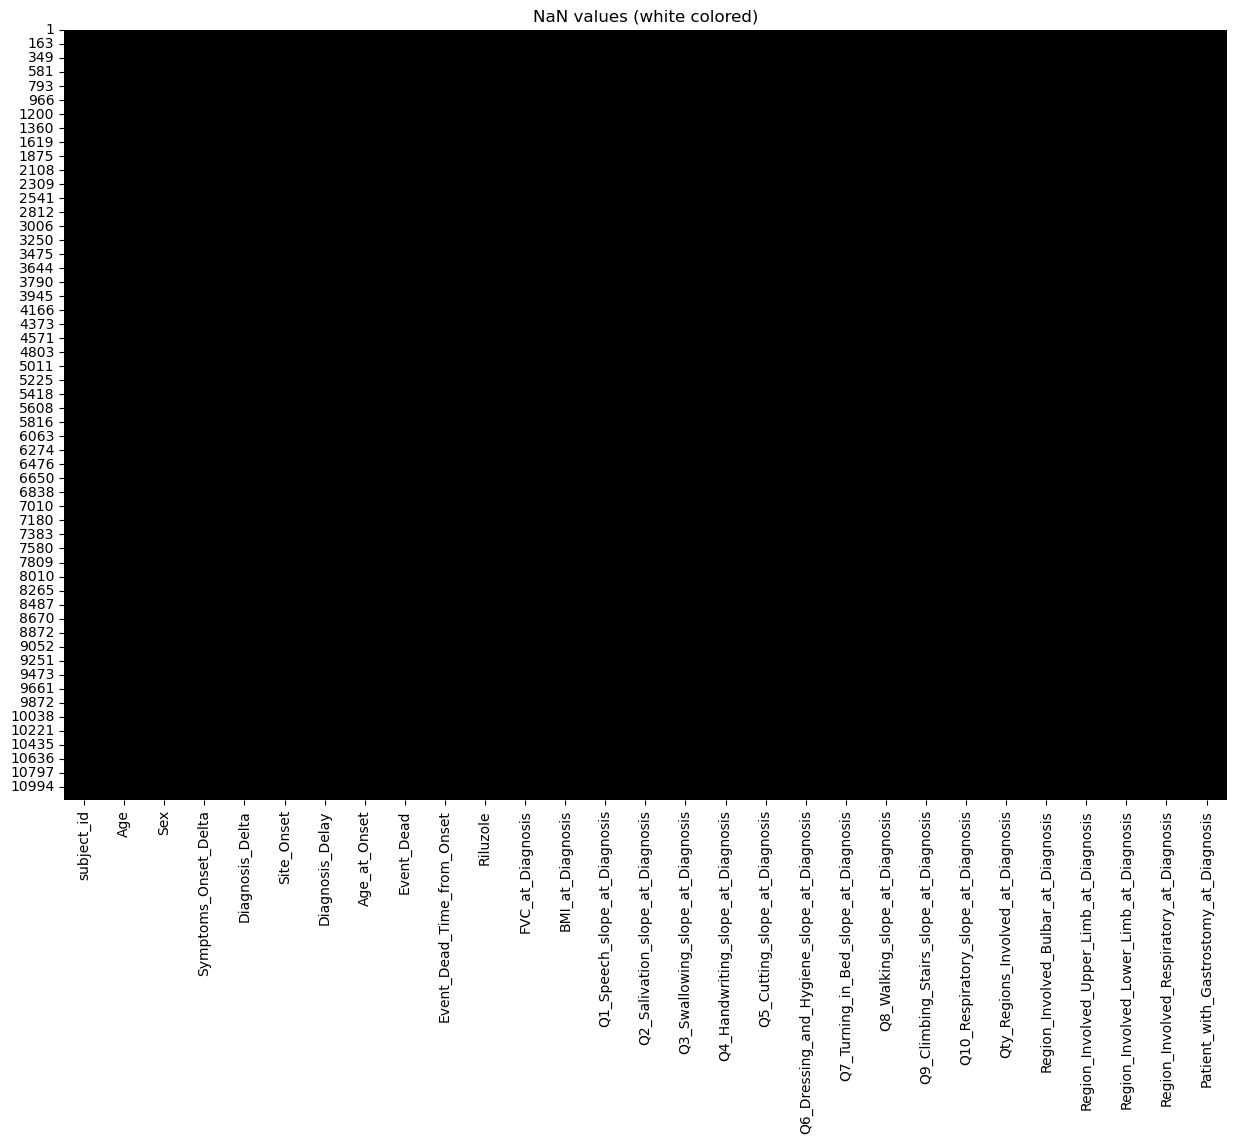

In [88]:
df_drop = df.dropna(subset=['Q1_Speech_slope_at_Diagnosis']).copy()
print(df_drop.shape[0])


df_drop = df_drop.dropna(subset=['Qty_Regions_Involved_at_Diagnosis']).copy()
print(df_drop.shape[0])

df_drop = df_drop.dropna(subset=['Patient_with_Gastrostomy_at_Diagnosis']).copy()
print(df_drop.shape[0])

# df_drop = df_drop.dropna(subset=['SVC_at_Diagnosis']).copy()
# print(df_drop.shape[0])
# remains 1242
df_drop = df_drop.drop(columns=['SVC_at_Diagnosis'])


# df_drop = df_drop.dropna(subset=['El_Escorial']).copy()
# print(df_drop.shape[0])
df_drop = df_drop.drop(columns=['El_Escorial'])


df_drop = df_drop.dropna(subset=['FVC_at_Diagnosis']).copy()
print(df_drop.shape[0])

df_drop = df_drop.dropna(subset=['BMI_at_Diagnosis']).copy()
print(df_drop.shape[0])


utils.plot_nan_values_heatmap(df_drop, title='NaN values (white colored)')

## Save the $complete\ cases$ samples ( $n=2,639$)

In [91]:
dir_dest = os.path.abspath('../03_preprocessed_data/')
csv_dest = f'{dir_dest}/patient_complete_cases.csv'
utils.save_to_csv(df=df_drop, csv_file=csv_dest)

2639 samples were saved


---
# 20. Group the patients into $Short$ and $Non\ Short$ survival groups
---

## Read the Complete-Cases CSV file saved in the previous step

In [5]:
# read the CSV file saved in the previous step
dir_data = os.path.abspath('../03_preprocessed_data/')
csv_file = f'{dir_data}/patient_complete_cases.csv'

df_complete_cases = utils.read_csv(csv_file=csv_file)
df_complete_cases.head()

,subject_id,Age,Sex,Symptoms_Onset_Delta,Diagnosis_Delta,Site_Onset,Diagnosis_Delay,Age_at_Onset,Event_Dead,Event_Dead_Time_from_Onset,...,Q7_Turning_in_Bed_slope_at_Diagnosis,Q8_Walking_slope_at_Diagnosis,Q9_Climbing_Stairs_slope_at_Diagnosis,Q10_Respiratory_slope_at_Diagnosis,Qty_Regions_Involved_at_Diagnosis,Region_Involved_Bulbar_at_Diagnosis,Region_Involved_Upper_Limb_at_Diagnosis,Region_Involved_Lower_Limb_at_Diagnosis,Region_Involved_Respiratory_at_Diagnosis,Patient_with_Gastrostomy_at_Diagnosis
0,329,38.0,Female,-1706.0,-1068.0,Limb/Spinal,21.0,0-39,False,65.0,...,0.02,0.02,0.02,0.01,4.0,1.0,1.0,1.0,1.0,0.0
1,533,65.0,Female,-1023.0,-44.0,Bulbar,32.0,60-69,False,46.0,...,0.00,0.03,0.03,0.03,3.0,1.0,0.0,1.0,1.0,0.0
2,586,63.0,Male,-715.0,-507.0,Bulbar,6.0,60-69,False,23.0,...,0.00,0.00,0.00,0.00,1.0,1.0,0.0,0.0,0.0,1.0
3,708,46.0,Male,-1070.0,-986.0,Bulbar,2.0,40-49,True,43.0,...,0.00,0.00,0.00,0.00,4.0,1.0,1.0,1.0,1.0,0.0
4,902,76.8,Female,-514.0,-49.0,Limb/Spinal,15.0,70+,False,21.0,...,0.00,0.05,0.16,0.00,2.0,1.0,0.0,1.0,0.0,0.0


## Group the patients

In [12]:
df_survival = utils_preprocessing.group_patients_into_short_and_non_short(df=df_complete_cases)
df_survival

,subject_id,Age,Sex,Symptoms_Onset_Delta,Diagnosis_Delta,Site_Onset,Diagnosis_Delay,Age_at_Onset,Event_Dead,Event_Dead_Time_from_Onset,...,Q8_Walking_slope_at_Diagnosis,Q9_Climbing_Stairs_slope_at_Diagnosis,Q10_Respiratory_slope_at_Diagnosis,Qty_Regions_Involved_at_Diagnosis,Region_Involved_Bulbar_at_Diagnosis,Region_Involved_Upper_Limb_at_Diagnosis,Region_Involved_Lower_Limb_at_Diagnosis,Region_Involved_Respiratory_at_Diagnosis,Patient_with_Gastrostomy_at_Diagnosis,Survival_Group
0,329,38.0,Female,-1706.0,-1068.0,Limb/Spinal,21.0,0-39,False,65.0,...,0.02,0.02,0.01,4.0,1.0,1.0,1.0,1.0,0.0,Non-Short
1,533,65.0,Female,-1023.0,-44.0,Bulbar,32.0,60-69,False,46.0,...,0.03,0.03,0.03,3.0,1.0,0.0,1.0,1.0,0.0,Non-Short
2,586,63.0,Male,-715.0,-507.0,Bulbar,6.0,60-69,False,23.0,...,0.00,0.00,0.00,1.0,1.0,0.0,0.0,0.0,1.0,Censored
3,708,46.0,Male,-1070.0,-986.0,Bulbar,2.0,40-49,True,43.0,...,0.00,0.00,0.00,4.0,1.0,1.0,1.0,1.0,0.0,Non-Short
4,902,76.8,Female,-514.0,-49.0,Limb/Spinal,15.0,70+,False,21.0,...,0.05,0.16,0.00,2.0,1.0,0.0,1.0,0.0,0.0,Censored
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2634,998542,70.0,Male,-287.0,-73.0,Limb/Spinal,7.0,70+,True,10.0,...,0.17,0.26,0.17,4.0,1.0,1.0,1.0,1.0,0.0,Short
2635,999166,60.0,Male,-999.0,-49.0,Bulbar,31.0,50-59,False,45.0,...,0.03,0.03,0.00,2.0,1.0,0.0,1.0,0.0,0.0,Non-Short
2636,999823,54.9,Male,-492.0,-84.0,Limb/Spinal,13.0,50-59,False,22.0,...,0.00,0.00,0.00,1.0,1.0,0.0,0.0,0.0,0.0,Censored
2637,999880,51.0,Male,-2865.0,-2105.0,Limb/Spinal,24.0,40-49,False,102.0,...,0.01,0.01,0.00,2.0,0.0,1.0,1.0,0.0,0.0,Non-Short


---
## Analyze the Survival_Group column

### _NOTE_: $653$ patients were marked as $Censored$, i.e, patients not marked as deceased having the last registered  visit lower than 24 months from symptom onset. Thus, we cannot affirm that they were alive after 24 months.

Column Survival_Group  (2639 rows)   (DataType: object)


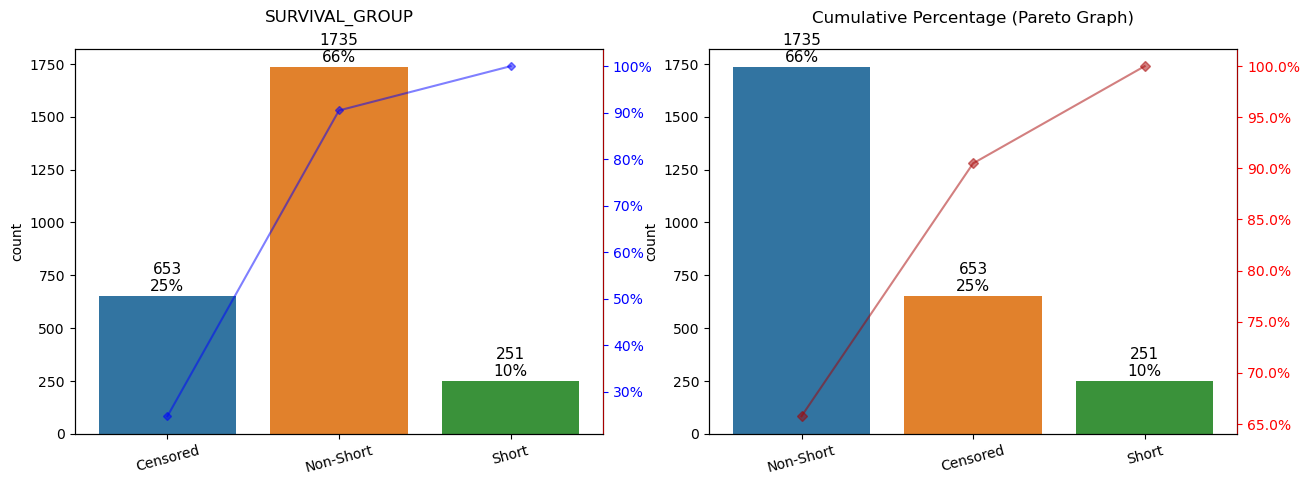

In [15]:
utils.plot_variable_distribution(series=df_survival.Survival_Group, print_more_info=False)


### Remove patients marked as $Censored$

  -  Previous=2639, To delete=653, After=1986
Column Survival_Group  (1986 rows)   (DataType: object)


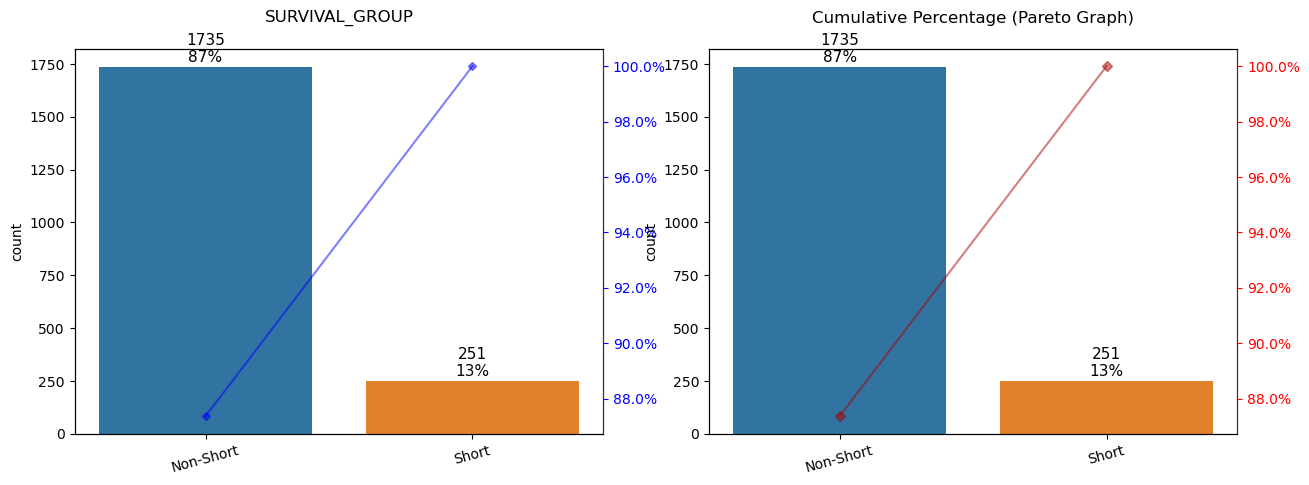

In [18]:
to_delete = df_survival.loc[(df_survival.Survival_Group=='Censored')]
df_survival = utils.remove_rows(df=df_survival, to_delete=to_delete)

utils.plot_variable_distribution(series=df_survival.Survival_Group, print_more_info=False)


---
## Remove patients having Site_Onset = 'Bulbar and Limb/Spinal' because they represent less than 1% of the samples (n=10)

Column Site_Onset  (1986 rows)   (DataType: object)


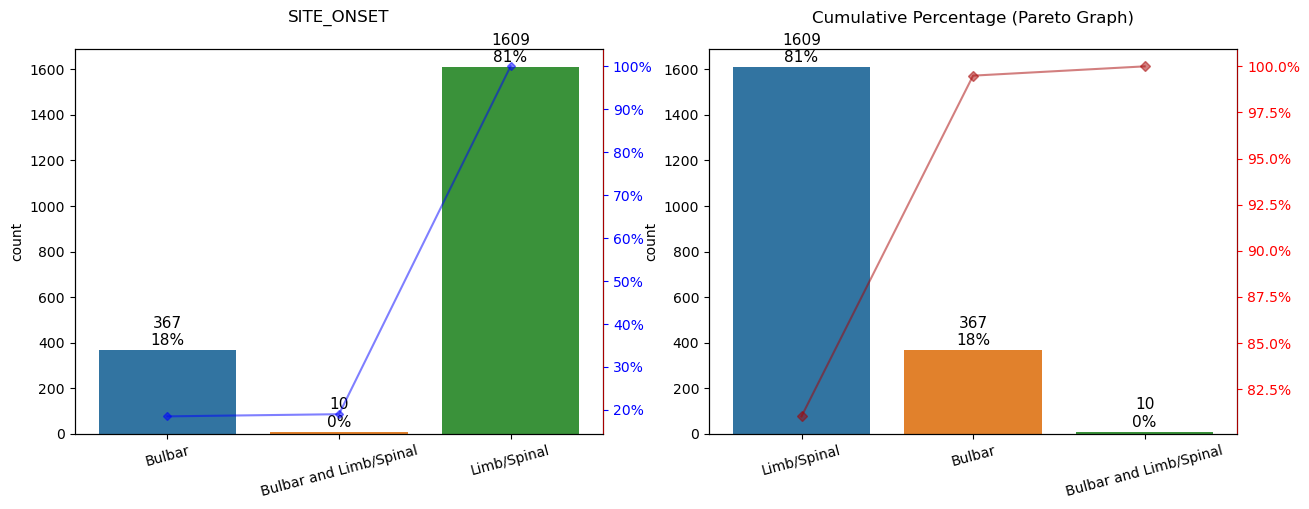


Removing samples...
  -  Previous=1986, To delete=10, After=1976
Column Site_Onset  (1976 rows)   (DataType: object)


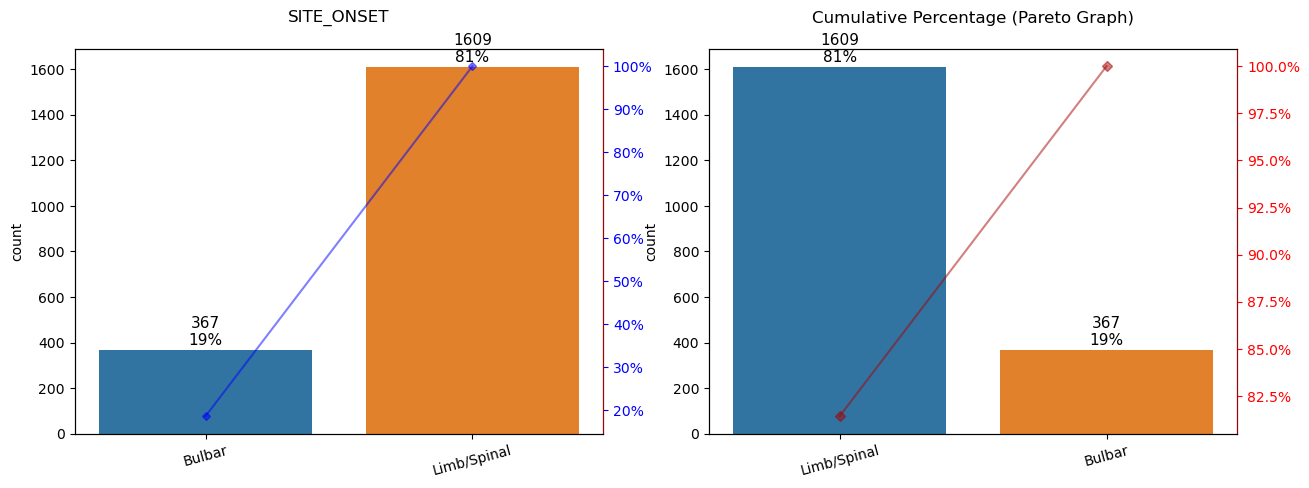

In [21]:
utils.plot_variable_distribution(series=df_survival.Site_Onset, print_more_info=False)

print()
print('Removing samples...')
# remove samples
to_delete = df_survival.loc[(df_survival.Site_Onset=='Bulbar and Limb/Spinal')]
df_survival = utils.remove_rows(df=df_survival, to_delete=to_delete)

utils.plot_variable_distribution(series=df_survival.Site_Onset, print_more_info=False)


---
## Remove patients having Qty_Regions_Involved = 0 because to diagnose the ALS it is need that at least one region be involved

Column Qty_Regions_Involved_at_Diagnosis  (1976 rows)   (DataType: float64)


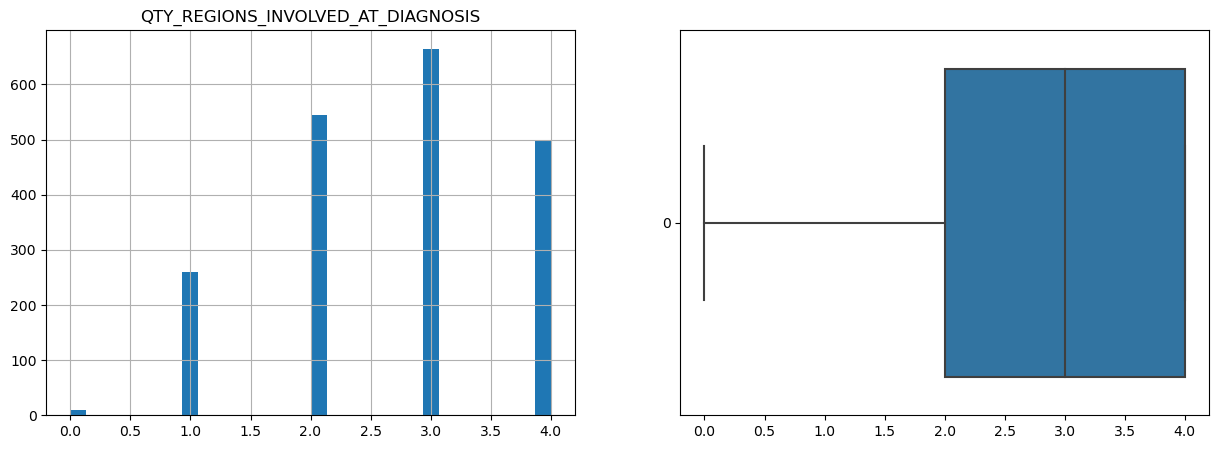


Removing samples...
  -  Previous=1976, To delete=9, After=1967
Column Qty_Regions_Involved_at_Diagnosis  (1967 rows)   (DataType: float64)


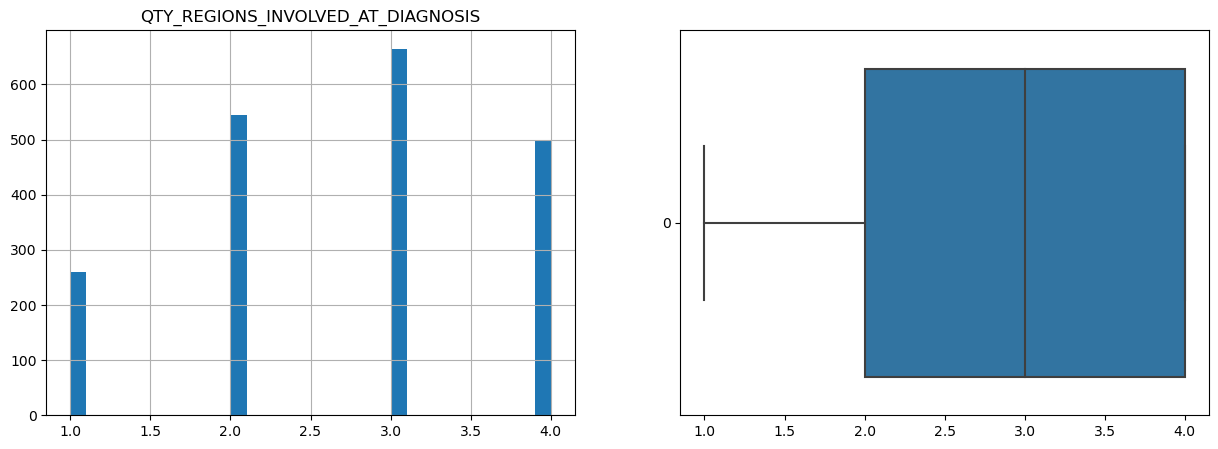

In [24]:
utils.plot_variable_distribution(series=df_survival.Qty_Regions_Involved_at_Diagnosis, print_more_info=False)

print()
print('Removing samples...')
# remove samples
to_delete = df_survival.loc[(df_survival.Qty_Regions_Involved_at_Diagnosis==0)]
df_survival = utils.remove_rows(df=df_survival, to_delete=to_delete)

utils.plot_variable_distribution(series=df_survival.Qty_Regions_Involved_at_Diagnosis, print_more_info=False)


## Save the final $complete\ cases$ samples after checking ( $n=1,967$)

In [29]:
df_survival

,subject_id,Age,Sex,Symptoms_Onset_Delta,Diagnosis_Delta,Site_Onset,Diagnosis_Delay,Age_at_Onset,Event_Dead,Event_Dead_Time_from_Onset,...,Q8_Walking_slope_at_Diagnosis,Q9_Climbing_Stairs_slope_at_Diagnosis,Q10_Respiratory_slope_at_Diagnosis,Qty_Regions_Involved_at_Diagnosis,Region_Involved_Bulbar_at_Diagnosis,Region_Involved_Upper_Limb_at_Diagnosis,Region_Involved_Lower_Limb_at_Diagnosis,Region_Involved_Respiratory_at_Diagnosis,Patient_with_Gastrostomy_at_Diagnosis,Survival_Group
0,329,38.0,Female,-1706.0,-1068.0,Limb/Spinal,21.0,0-39,False,65.0,...,0.02,0.02,0.01,4.0,1.0,1.0,1.0,1.0,0.0,Non-Short
1,533,65.0,Female,-1023.0,-44.0,Bulbar,32.0,60-69,False,46.0,...,0.03,0.03,0.03,3.0,1.0,0.0,1.0,1.0,0.0,Non-Short
3,708,46.0,Male,-1070.0,-986.0,Bulbar,2.0,40-49,True,43.0,...,0.00,0.00,0.00,4.0,1.0,1.0,1.0,1.0,0.0,Non-Short
6,1736,40.0,Male,-570.0,-511.0,Limb/Spinal,2.0,0-39,False,36.0,...,0.02,0.02,0.01,4.0,1.0,1.0,1.0,1.0,0.0,Non-Short
7,1835,64.0,Male,-765.0,-569.0,Limb/Spinal,6.0,60-69,False,25.0,...,0.00,0.00,0.02,2.0,0.0,1.0,0.0,1.0,0.0,Non-Short
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2631,998019,57.4,Male,-286.0,-135.0,Bulbar,5.0,50-59,True,10.0,...,0.18,0.24,0.06,4.0,1.0,1.0,1.0,1.0,0.0,Short
2633,998519,42.0,Female,-653.0,-475.0,Limb/Spinal,5.0,40-49,False,30.0,...,0.03,0.05,0.00,2.0,0.0,1.0,1.0,0.0,0.0,Non-Short
2634,998542,70.0,Male,-287.0,-73.0,Limb/Spinal,7.0,70+,True,10.0,...,0.17,0.26,0.17,4.0,1.0,1.0,1.0,1.0,0.0,Short
2635,999166,60.0,Male,-999.0,-49.0,Bulbar,31.0,50-59,False,45.0,...,0.03,0.03,0.00,2.0,1.0,0.0,1.0,0.0,0.0,Non-Short


In [30]:
cols_of_interest = [
#     'subject_id',
#     'Age',
    'Sex',
#     'Symptoms_Onset_Delta',
#     'Diagnosis_Delta',
    'Site_Onset',
    'Diagnosis_Delay',
    'Age_at_Onset',
#     'Event_Dead',
#     'Event_Dead_Time_from_Onset',
    'Riluzole',
    'FVC_at_Diagnosis',
    'BMI_at_Diagnosis',
    'Q1_Speech_slope_at_Diagnosis',
    'Q2_Salivation_slope_at_Diagnosis',
    'Q3_Swallowing_slope_at_Diagnosis',
    'Q4_Handwriting_slope_at_Diagnosis',
    'Q5_Cutting_slope_at_Diagnosis',
    'Q6_Dressing_and_Hygiene_slope_at_Diagnosis',
    'Q7_Turning_in_Bed_slope_at_Diagnosis',
    'Q8_Walking_slope_at_Diagnosis',
    'Q9_Climbing_Stairs_slope_at_Diagnosis',
    'Q10_Respiratory_slope_at_Diagnosis',
    'Qty_Regions_Involved_at_Diagnosis',
    'Region_Involved_Bulbar_at_Diagnosis',
    'Region_Involved_Upper_Limb_at_Diagnosis',
    'Region_Involved_Lower_Limb_at_Diagnosis',
    'Region_Involved_Respiratory_at_Diagnosis',
    'Patient_with_Gastrostomy_at_Diagnosis',
    'Survival_Group',   
]

# select only the columns of interest
df_survival = df_survival[cols_of_interest]

dir_dest = os.path.abspath('../04_data_to_analyze/')
csv_dest = f'{dir_dest}/patient_preprocessed.csv'
utils.save_to_csv(df=df_survival, csv_file=csv_dest)

1967 samples were saved


---
# 21. Save a copy of $complete\ cases$ with coded values, performing data categorization and dummy variables creation
---

In [90]:
df_coded = utils_preprocessing.perform_data_codification(df_patients=df_survival)
display(df_coded)

# save coded data
dir_dest = os.path.abspath('../04_data_to_analyze/')
csv_dest = f'{dir_dest}/patient_preprocessed_coded.csv'
utils.save_to_csv(df=df_coded, csv_file=csv_dest)

,Sex_Male,Site_Onset,Diagnosis_Delay,Age_at_Onset,Riluzole,FVC_at_Diagnosis,BMI_at_Diagnosis,Q1_Speech_slope_at_Diagnosis,Q2_Salivation_slope_at_Diagnosis,Q3_Swallowing_slope_at_Diagnosis,...,Q8_Walking_slope_at_Diagnosis,Q9_Climbing_Stairs_slope_at_Diagnosis,Q10_Respiratory_slope_at_Diagnosis,Qty_Regions_Involved_at_Diagnosis,Region_Involved_Bulbar_at_Diagnosis,Region_Involved_Upper_Limb_at_Diagnosis,Region_Involved_Lower_Limb_at_Diagnosis,Region_Involved_Respiratory_at_Diagnosis,Patient_with_Gastrostomy_at_Diagnosis,Survival_Group
0,0,1,2,0,0,0,1,0,0,0,...,0,0,0,4,1,1,1,1,0,0
1,0,0,2,3,0,0,1,1,1,1,...,0,0,0,3,1,0,1,1,0,0
3,1,0,0,1,0,1,1,0,0,0,...,0,0,0,4,1,1,1,1,0,0
6,1,1,0,0,0,0,3,0,0,0,...,0,0,0,4,1,1,1,1,0,0
7,1,1,0,3,1,0,1,0,0,0,...,0,0,0,2,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2631,1,0,0,2,0,1,2,1,2,1,...,2,2,1,4,1,1,1,1,0,1
2633,0,1,0,1,0,1,1,0,0,0,...,0,1,0,2,0,1,1,0,0,0
2634,1,1,0,4,0,0,2,0,1,0,...,2,2,2,4,1,1,1,1,0,1
2635,1,0,2,2,0,0,2,0,0,0,...,0,0,0,2,1,0,1,0,0,0


1967 samples were saved


---
# 22. Save a copy of $complete\ cases$ scaling the values between $0$ and $1$
---
### _NOTE_: this file will be used by the Machine Learning algorithms

In [91]:
df_scaled = utils_preprocessing.perform_data_scaling(df_coded=df_coded)

display(df_scaled)

# save scaled data
dir_dest = os.path.abspath('../04_data_to_analyze/')
csv_dest = f'{dir_dest}/patient_preprocessed_scaled.csv'
utils.save_to_csv(df=df_scaled, csv_file=csv_dest)

,Sex_Male,Site_Onset,Diagnosis_Delay,Age_at_Onset,Riluzole,FVC_at_Diagnosis,BMI_at_Diagnosis,Q1_Speech_slope_at_Diagnosis,Q2_Salivation_slope_at_Diagnosis,Q3_Swallowing_slope_at_Diagnosis,...,Q8_Walking_slope_at_Diagnosis,Q9_Climbing_Stairs_slope_at_Diagnosis,Q10_Respiratory_slope_at_Diagnosis,Qty_Regions_Involved_at_Diagnosis,Region_Involved_Bulbar_at_Diagnosis,Region_Involved_Upper_Limb_at_Diagnosis,Region_Involved_Lower_Limb_at_Diagnosis,Region_Involved_Respiratory_at_Diagnosis,Patient_with_Gastrostomy_at_Diagnosis,Survival_Group
0,0.0,1.0,1.0,0.00,0.0,0.0,0.33,0.0,0.0,0.0,...,0.0,0.0,0.0,1.00,1.0,1.0,1.0,1.0,0.0,0.0
1,0.0,0.0,1.0,0.75,0.0,0.0,0.33,0.5,0.5,0.5,...,0.0,0.0,0.0,0.67,1.0,0.0,1.0,1.0,0.0,0.0
3,1.0,0.0,0.0,0.25,0.0,1.0,0.33,0.0,0.0,0.0,...,0.0,0.0,0.0,1.00,1.0,1.0,1.0,1.0,0.0,0.0
6,1.0,1.0,0.0,0.00,0.0,0.0,1.00,0.0,0.0,0.0,...,0.0,0.0,0.0,1.00,1.0,1.0,1.0,1.0,0.0,0.0
7,1.0,1.0,0.0,0.75,1.0,0.0,0.33,0.0,0.0,0.0,...,0.0,0.0,0.0,0.33,0.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2631,1.0,0.0,0.0,0.50,0.0,1.0,0.67,0.5,1.0,0.5,...,1.0,1.0,0.5,1.00,1.0,1.0,1.0,1.0,0.0,1.0
2633,0.0,1.0,0.0,0.25,0.0,1.0,0.33,0.0,0.0,0.0,...,0.0,0.5,0.0,0.33,0.0,1.0,1.0,0.0,0.0,0.0
2634,1.0,1.0,0.0,1.00,0.0,0.0,0.67,0.0,0.5,0.0,...,1.0,1.0,1.0,1.00,1.0,1.0,1.0,1.0,0.0,1.0
2635,1.0,0.0,1.0,0.50,0.0,0.0,0.67,0.0,0.0,0.0,...,0.0,0.0,0.0,0.33,1.0,0.0,1.0,0.0,0.0,0.0


1967 samples were saved
